# Project Exploration
## The Dataset and What we hope to do with it:
- The dataset we are using is the concatenated data of the 2015 Human Development Report, taken from Kaggle and developed by the United Nations.
- This data includes the average, standard deviation, min, and max of all variables that are a float, which is nice for describing it.
- It uses 45 variables that are supposed to describe the development of each of 195 listed countries. 
- A weird and potentially troublesome thing about this is it doesn't include all countries and has some 'countries' that are not always considered countries by definition. We will thus be taking out the 'countries' that are not recognized by the formal United Nations.
- Another issue is that there is a limitation of validity because the numbers are self reported and in some categories absent. We plan to take out some countries for their absence of data (taking out any with more than 10 missing values) and take our results with a grain of salt.

Our problem/goal: We hope to be able to use our model to find the GDI (Gender Development Index) from the HDI (Human Development Index) within the MDI (Multidimensional Poverty Index) of any country with our dataset. 
- We are going to keep the whole concatonated dataset and the MPI dataset seperate because they refer to different countries and we want to make multiple regression models that fit the NaN values between them before combining the dataset.

## Descriptive plots and graphs:

In [232]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
import sklearn
import numpy as np
from pprint import pprint
import math 
import locale
from locale import atof
import numpy.random as rn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor


locale.setlocale(locale.LC_NUMERIC, '')

gd_data = read_csv("https://www.dropbox.com/s/upot2a908xz26mn/gender_development.csv?dl=1")
gi_data = read_csv("https://www.dropbox.com/s/ensgp6e3chobe5x/gender_inequality.csv?dl=1")
hi_data = read_csv("https://www.dropbox.com/s/3u7udv2hlseddcb/historical_index.csv?dl=1")
ia_data = read_csv("https://www.dropbox.com/s/t7z4t0dj0ik16vc/inequality_adjusted.csv?dl=1")
hd_data = read_csv("https://www.dropbox.com/s/pjijqqsebk9vuwl/human_development.csv?dl=1")
mpi_data = read_csv('https://www.dropbox.com/s/jq78geqaa7qaobs/multidimensional_poverty.csv?dl=1')

In [233]:
whole_data = pd.concat([gd_data, gi_data,hd_data,ia_data,hi_data],axis=1,sort=False, copy = True).drop(['HDI Rank',
       'Human Development Index (HDI)'], axis =1)

In [234]:
whole_data = whole_data.loc[:,~whole_data.columns.duplicated()]

In [235]:
for column in whole_data.columns:
    for row in whole_data.index: 
        if whole_data.loc[row,column] == '..':
            whole_data.loc[row,column]= np.nan
for column in mpi_data.columns:
    for row in mpi_data.index: 
        if mpi_data.loc[row,column] == '..':
            mpi_data.loc[row,column]= np.nan

In [236]:
whole_data.drop(whole_data.index[188:194], axis =0)
whole_data =whole_data.drop(['Income Inequality (Quintile Ratio)','Income Inequality (Palma Rati)', 'Income Inequality (Gini Coefficient)'], axis =1)

In [237]:
mpi_data.head()

,Country,Year and Survey,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,2010/2011 M,0.293,58.8,0.353,66.2,"17,116",49.9,45.6,19.2,35.2,35.8,NaN
1,Albania,2008/2009 D,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Argentina,2005 N,0.015,3.7,0.011,2.9,"1,438",39.1,38.2,27.8,34.0,NaN,1.4
3,Armenia,2010 D,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32.0,1.8
4,Azerbaijan,2006 D,0.009,2.4,0.021,5.3,210,38.2,20.0,50.7,29.3,5.3,0.3


In [238]:
for col in whole_data.columns:
    if col != 'Country':
        for i in range(len(whole_data[col])):
            if type(whole_data[col][i]) not in [np.float64, float] and whole_data[col][i] is not None:
                whole_data[col][i] = np.float64(whole_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [239]:
for col in mpi_data.columns:
    if col != 'Country' and col != 'Year and Survey':
        for i in range(len(mpi_data[col])):
            if type(mpi_data[col][i]) not in [np.float64, float] and mpi_data[col][i] is not None:
                mpi_data[col][i] = np.float64(mpi_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Regression Models for Filling Gaps
## Now we need to create regression models to fill in non-existant data points. To do this we must first drop points that have little to no data. 
- We use the loc feature to find all NaN  points. If there are >10 we will delete th erow to protect the integrity of the model. The following must be removed from the data set

- 'Hong Kong, China (SAR)'
- 'Liechtenstein'
- 'Brunei Darussalam' 
- 'Andorra' 
- 'Bahamas'
- 'Antigua and Barbuda'
- 'Palau'
- 'Seychelles' 
- 'Saint Kitts and Nevis'
- 'Grenada'
- 'Bosnia and Herzegovina'
- 'Dominica'
- 'Saint Vincent and the Grenadines'
- 'Turkmenistan'
- 'Gabon'
- 'Viet Nam'
- 'Cabo Verde'
- 'Micronesia (Federated States of)'
- 'Kiribati'
- 'Equatorial Guinea'
- 'Myanmar'
- 'Angola'
- 'Solomon Islands'
- 'Papua New Guinea'
- 'Haiti'
- 'Djibouti'
- 'Guinea-Bissau'
- 'Eritrea'

In [240]:
whole_data = whole_data.drop([whole_data.index[11], whole_data.index[12], whole_data.index[30], whole_data.index[33],
                 whole_data.index[54], whole_data.index[57] ,whole_data.index[59], whole_data.index[63], whole_data.index[76],
                 whole_data.index[78], whole_data.index[86], whole_data.index[93], whole_data.index[97],
                 whole_data.index[108], whole_data.index[109], whole_data.index[117], whole_data.index[121],
                 whole_data.index[122], whole_data.index[137], whole_data.index[136], whole_data.index[147],
                 whole_data.index[148], whole_data.index[156], whole_data.index[157], whole_data.index[162],
                 whole_data.index[167], whole_data.index[177], whole_data.index[185]], axis =0)
## Drop Year and survey 
mpi_data = mpi_data.drop(mpi_data.columns[1], axis =1)

In [241]:
for column in whole_data.columns:
    df = whole_data[pd.notna(whole_data.loc[:,column])]
    df = df.dropna()

## whole_data
#### Now we need to find regression models (and test using bootstrapping and cross validation) for:
- Inequality in Education                                 
- Inequality-Adjusted Education Index                        
- Inequality in Income                                       
- Inequality-Adjusted Income Index 
- Inequality-adjusted HDI (IHDI)         
- IHDI Loss Percent                                         
- IHDI Rank Difference                                      
- Coefficient of Human Inequality                           
- Inequality in Life Expectancy  

##### We will create a vanilla regression, a  ridge regression, and lasso regression models for each to determine the missing values
______________________________________________________________________
# Functions

In [242]:
def createTestTrain(data,labelX,labely):
    X = np.atleast_2d(np.array([float(h) for h in data.loc[:, labelX].dropna()])).transpose()
    y = np.array(data.loc[:,labely])
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)
    X = X[perm]
    y = y[perm]
    X_test = X[:test]      
    y_test = y[:test]
    X_train = X[test:]     
    y_train = y[test:]
    return X_test, y_test, X_train, y_train, X, y

In [243]:
def crossVal(X,y):  
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    R2 = pd.DataFrame( np.array([ [0]*5, [0]*5, [0]*5, [0]*5]).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])
    

    for k in range(5):
        X_test = X[k*test:(k+1)*test]      
        y_test = y[k*test:(k+1)*test]
        X_train = np.concatenate( (X[:k*test], X[(k+1)*test:]), axis=0)     
        y_train = np.concatenate( (y[:k*test], y[(k+1)*test:]), axis=0)
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = [0, 1, 2, 3, 4, 'Mean', 'Standard Deviation']
    return R2

In [244]:
def boots(X,y):
    num = 40 
    Xboot = [0]*num
    yboot = [0]*num

    n = X.shape[0]
    for k in range(num):
        sample = np.random.randint(0, n, n) 
        Xboot[k] = X[sample, :]
        yboot[k] = y[sample]
    test = int(0.20*n)
    R2 = pd.DataFrame( np.array([ [0]*num]*4).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])

    for k in range(num):
        X_test = Xboot[k][:test]
        y_test = yboot[k][:test]
        X_train = Xboot[k][test:]
        y_train = yboot[k][test:]
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = list(range(num)) + ['Mean', 'Standard Deviation']
    return R2.tail(10)

In [245]:
def plotfig():
    plt.plot(X_train, y_train, 'b.')
    plt.plot(X_test, y_test, 'g*')
    xx = np.linspace(0, 1.2, 20)
    yy = b + m*xx
    plt.plot(xx, yy, 'm-')

In [246]:
def filldata(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,44]
            data.iloc[row,index] = m*x+b

In [247]:
def filldatampi(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,2]
            data.iloc[row,index] = m*x+b

In [248]:
def plot_reg_model(reg, X, y):

    # We shuffle the data using a random permutation

    n = X.shape[0]
    test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]       # Then create the test
    y_test = y[:test]
    X_train = X[test:]     # and train sets
    y_train = y[test:]
    
    reg.fit(X_train, y_train) # Fit the model
     
    nn = 200
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),   # Changed the function to use linspace rather than arrange
        np.linspace(y_min, y_max, nn))                    # This keeps us from having to adjust h.
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()]) # predict

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))
    
    return reg

### Inequality in Education:

In [249]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Education")

69.31486747399248 -71.33015256293976


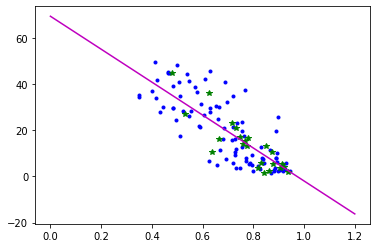

In [250]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [251]:
filldata(whole_data,m,b,34)

In [252]:
crossVal(X,y) 

,train_1,test_1,train_2,test_2
0,0.634708,0.676808,0.634708,0.676808
1,0.635887,0.710236,0.635887,0.710236
2,0.624010,0.754381,0.624010,0.754381
3,0.684551,0.542727,0.684551,0.542727
4,0.693239,-0.191542,0.693239,-0.191542
Mean,0.654479,0.498522,0.654479,0.498522
Standard Deviation,0.028536,0.352198,0.028536,0.352198


In [253]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.678362,0.674342,0.678362,0.674342
33,0.685558,0.727524,0.685558,0.727524
34,0.668557,0.769876,0.668557,0.769876
35,0.657130,0.570338,0.657130,0.570338
36,0.603442,0.713261,0.603442,0.713261
37,0.670101,0.593290,0.670101,0.593290
38,0.634004,0.726085,0.634004,0.726085
39,0.665295,0.697222,0.665295,0.697222
Mean,0.634663,0.509989,0.634663,0.509989
Standard Deviation,0.023576,0.085736,0.023576,0.085736


### Inequality-Adjusted Education Index:

In [254]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Education Index")

-0.33293500296605527 1.2493963016076037


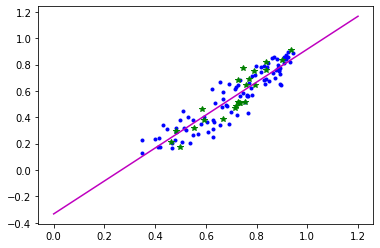

In [255]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [256]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8581735847230099
The testing R2: 0.8414915357870975


In [257]:
filldata(whole_data,m,b,35)

In [258]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.853285,0.862976,0.853285,0.862976
1,0.845544,0.886338,0.845544,0.886338
2,0.863792,0.828977,0.863792,0.828977
3,0.852093,0.865958,0.852093,0.865958
4,0.862390,0.814460,0.862390,0.814460
Mean,0.855421,0.851742,0.855421,0.851742
Standard Deviation,0.006809,0.026205,0.006809,0.026205


In [259]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.850566,0.888562,0.850566,0.888562
33,0.818086,0.831180,0.818086,0.831180
34,0.877929,0.907965,0.877929,0.907965
35,0.826378,0.865176,0.826378,0.865176
36,0.861438,0.766929,0.861438,0.766929
37,0.863819,0.824618,0.863819,0.824618
38,0.842486,0.830817,0.842486,0.830817
39,0.873289,0.844157,0.873289,0.844157
Mean,0.862437,0.823967,0.862437,0.823967
Standard Deviation,0.030637,0.072497,0.030637,0.072497


### Inequality-Adjusted Income Index:

In [260]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Income Index")

-0.1588335542511834 0.9771046427421565


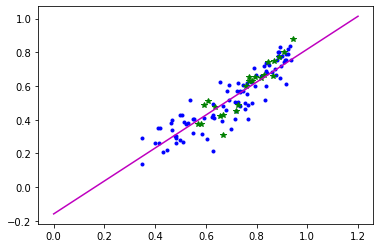

In [261]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [262]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.815479553801588
The testing R2: 0.7987481908600711


In [263]:
filldata(whole_data,m,b,37)

In [264]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.803237,0.865104,0.803237,0.865104
1,0.822933,0.787458,0.822933,0.787458
2,0.837473,0.726808,0.837473,0.726808
3,0.792769,0.882588,0.792769,0.882588
4,0.829898,0.737760,0.829898,0.737760
Mean,0.817262,0.799944,0.817262,0.799944
Standard Deviation,0.016715,0.063949,0.016715,0.063949


In [265]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.839971,0.851282,0.839971,0.851282
33,0.802690,0.835611,0.802690,0.835611
34,0.801470,0.757161,0.801470,0.757161
35,0.868613,0.906962,0.868613,0.906962
36,0.833725,0.886631,0.833725,0.886631
37,0.883617,0.681939,0.883617,0.681939
38,0.805506,0.855008,0.805506,0.855008
39,0.842643,0.848097,0.842643,0.848097
Mean,0.839010,0.788910,0.839010,0.788910
Standard Deviation,0.025728,0.072865,0.025728,0.072865


### Inequality-adjusted HDI (IHDI):

In [266]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality-adjusted HDI (IHDI)")

-0.25061663142931556 1.172185970301005


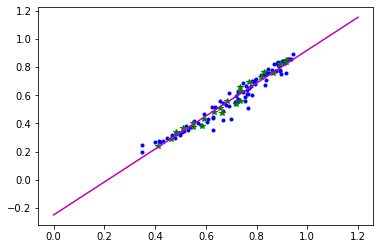

In [267]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [268]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.9513980000899266
The testing R2: 0.9717544815081677


In [269]:
filldata(whole_data,m,b,28)

In [270]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.958688,0.936636,0.958688,0.936636
1,0.955125,0.955790,0.955125,0.955790
2,0.949231,0.973218,0.949231,0.973218
3,0.959326,0.925123,0.959326,0.925123
4,0.954132,0.948698,0.954132,0.948698
Mean,0.955300,0.947893,0.955300,0.947893
Standard Deviation,0.003631,0.016429,0.003631,0.016429


In [271]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.959208,0.901527,0.959208,0.901527
33,0.966940,0.978548,0.966940,0.978548
34,0.947604,0.984676,0.947604,0.984676
35,0.964839,0.982765,0.964839,0.982765
36,0.950180,0.933774,0.950180,0.933774
37,0.957707,0.981738,0.957707,0.981738
38,0.945869,0.929996,0.945869,0.929996
39,0.966692,0.980306,0.966692,0.980306
Mean,0.962625,0.960579,0.962625,0.960579
Standard Deviation,0.007905,0.016935,0.007905,0.016935


### IHDI Loss Percent:

In [272]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","IHDI Loss Percent")

61.49436820336863 -58.67907537779402


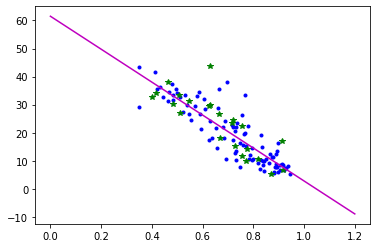

In [273]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [274]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.7712791361107284
The testing R2: 0.6683322240941728


In [275]:
filldata(whole_data,m,b,29)

In [276]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.776113,0.677484,0.776113,0.677484
1,0.792947,0.579834,0.792947,0.579834
2,0.732088,0.827797,0.732088,0.827797
3,0.769324,0.694979,0.769324,0.694979
4,0.718735,0.907870,0.718735,0.907870
Mean,0.757841,0.737593,0.757841,0.737593
Standard Deviation,0.027895,0.116145,0.027895,0.116145


In [277]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.730273,0.822818,0.730273,0.822818
33,0.733829,0.644482,0.733829,0.644482
34,0.801150,0.819862,0.801150,0.819862
35,0.763968,0.639347,0.763968,0.639347
36,0.764469,0.648547,0.764469,0.648547
37,0.727937,0.771609,0.727937,0.771609
38,0.727215,0.610643,0.727215,0.610643
39,0.770060,0.744302,0.770060,0.744302
Mean,0.771981,0.684291,0.771981,0.684291
Standard Deviation,0.025888,0.080956,0.025888,0.080956


### Coefficient of Human Inequality:

In [278]:
X_test, y_test, X_train, y_train,X, y = createTestTrain(df,"Human Development Index (2014)","Coefficient of Human Inequality")

59.876750842084746 -57.36482526564527


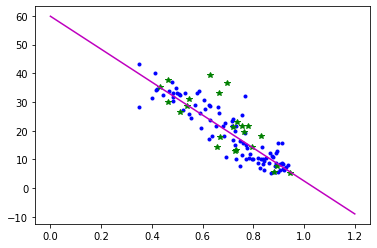

In [279]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [280]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.81762424447041
The testing R2: 0.573495402524302


In [281]:
filldata(whole_data,m,b,31)

In [282]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.784821,0.717795,0.784821,0.717795
1,0.753345,0.846998,0.753345,0.846998
2,0.788734,0.699377,0.788734,0.699377
3,0.772613,0.790741,0.772613,0.790741
4,0.761197,0.803152,0.761197,0.803152
Mean,0.772142,0.771612,0.772142,0.771612
Standard Deviation,0.013486,0.055060,0.013486,0.055060


In [283]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.744555,0.727578,0.744555,0.727578
33,0.828213,0.837619,0.828213,0.837619
34,0.852685,0.798560,0.852685,0.798560
35,0.797649,0.687974,0.797649,0.687974
36,0.753593,0.725717,0.753593,0.725717
37,0.805442,0.801058,0.805442,0.801058
38,0.858689,0.789916,0.858689,0.789916
39,0.781072,0.763783,0.781072,0.763783
Mean,0.766977,0.745404,0.766977,0.745404
Standard Deviation,0.026608,0.105651,0.026608,0.105651


### Inequality in Life Expectancy: 

In [284]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Life Expectancy")

70.18769816702108 -75.56993593925566


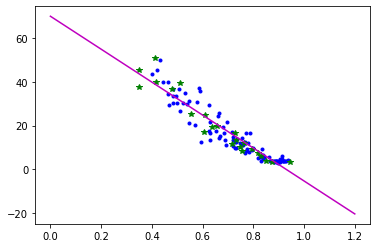

In [285]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [286]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8777001014377916
The testing R2: 0.9111280653285434


In [287]:
filldata(whole_data,m,b,31)

In [288]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.884227,0.902225,0.884227,0.902225
1,0.884719,0.879556,0.884719,0.879556
2,0.893200,0.847276,0.893200,0.847276
3,0.882895,0.901322,0.882895,0.901322
4,0.897134,0.710684,0.897134,0.710684
Mean,0.888435,0.848213,0.888435,0.848213
Standard Deviation,0.005667,0.071604,0.005667,0.071604


In [289]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.897357,0.843135,0.897357,0.843135
33,0.857378,0.915178,0.857378,0.915178
34,0.897460,0.881752,0.897460,0.881752
35,0.903567,0.920716,0.903567,0.920716
36,0.891566,0.862970,0.891566,0.862970
37,0.890466,0.827727,0.890466,0.827727
38,0.904803,0.921922,0.904803,0.921922
39,0.901123,0.844252,0.901123,0.844252
Mean,0.884606,0.880414,0.884606,0.880414
Standard Deviation,0.024564,0.030400,0.024564,0.030400


## mpi_data
#### We need to find regression models for:
- Population Below National Poverty Line
- Population Below $1.25 per Day

In [290]:
for column in mpi_data.columns:
    df = mpi_data[pd.notna(mpi_data.loc[:,column])]
    df = df.dropna()

In [291]:
mpi_data.columns.get_loc("Population Below $1.25 per Day")

11

### Population Below National Poverty Line

In [292]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below National Poverty Line")

23.72482953772539 65.00175327734155


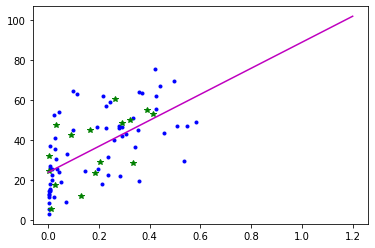

In [293]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [294]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.37808978213817845
The testing R2: 0.357574217913746


In [295]:
filldatampi(mpi_data, m, b, 11)

In [296]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.380003,0.263486,0.380003,0.263486
1,0.343746,0.439024,0.343746,0.439024
2,0.426831,0.089618,0.426831,0.089618
3,0.352971,0.446063,0.352971,0.446063
4,0.375474,0.369944,0.375474,0.369944
Mean,0.375805,0.321627,0.375805,0.321627
Standard Deviation,0.028881,0.133274,0.028881,0.133274


In [297]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.372762,0.461295,0.372762,0.461295
33,0.370285,0.588632,0.370285,0.588632
34,0.306341,0.130215,0.306341,0.130215
35,0.357767,0.621694,0.357767,0.621694
36,0.404867,0.263721,0.404867,0.263721
37,0.389905,0.200791,0.389905,0.200791
38,0.355195,0.495933,0.355195,0.495933
39,0.602230,0.555106,0.602230,0.555106
Mean,0.421979,0.233123,0.421979,0.233123
Standard Deviation,0.072124,0.154749,0.072124,0.154749


### Population Below 1.25 per Day:

In [298]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below $1.25 per Day")

3.2249956742403043 126.66304938659334


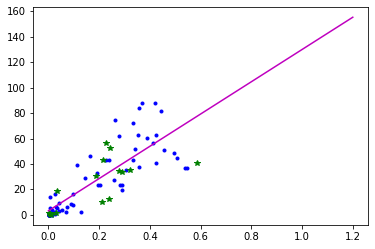

In [299]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [300]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.6797272936652613
The testing R2: 0.38581181712271406


In [301]:
filldatampi(mpi_data, m, b, 11)

In [302]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.652825,0.625742,0.652825,0.625742
1,0.700548,0.221897,0.700548,0.221897
2,0.640854,0.655050,0.640854,0.655050
3,0.627554,0.697471,0.627554,0.697471
4,0.626547,0.694234,0.626547,0.694234
Mean,0.649665,0.578879,0.649665,0.578879
Standard Deviation,0.027203,0.180447,0.027203,0.180447


In [303]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.645042,0.615271,0.645042,0.615271
33,0.569532,0.544601,0.569532,0.544601
34,0.724756,0.641855,0.724756,0.641855
35,0.668339,0.480836,0.668339,0.480836
36,0.612206,0.517537,0.612206,0.517537
37,0.749145,0.676129,0.749145,0.676129
38,0.596997,0.688639,0.596997,0.688639
39,0.664549,0.697236,0.664549,0.697236
Mean,0.611951,0.531656,0.611951,0.531656
Standard Deviation,0.028872,0.093389,0.028872,0.093389


In [304]:
whole_data = whole_data.dropna()

In [305]:
mpi_data =mpi_data.dropna()

In [306]:
wd_set =set(whole_data.iloc[:,1].to_list())
mpi_set=set(mpi_data.iloc[:,0].to_list())

In [307]:
new_countries =mpi_set.intersection(wd_set.intersection(mpi_set))

In [308]:
keep = list(new_countries)
new_whole_data = whole_data
for i in whole_data.index:
    if not whole_data.loc[i,"Country"] in keep:
        new_whole_data = new_whole_data.drop(i, axis=0)

In [309]:
new_mpi_data = mpi_data
for i in mpi_data.index:
    if not mpi_data.loc[i,"Country"] in keep:
        new_mpi_data = new_mpi_data.drop(i, axis=0)

In [310]:
new_whole_data = new_whole_data.sort_values('Country').reset_index()
new_whole_data.head()

,index,GDI Rank,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),...,Inequality-Adjusted Education Index,Inequality in Income,Inequality-Adjusted Income Index,Human Development Index (1990),Human Development Index (2000),Human Development Index (2010),Human Development Index (2011),Human Development Index (2012),Human Development Index (2013),Human Development Index (2014)
0,170,171.0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,11.3,...,0.202,10.8,0.396,0.297,0.334,0.448,0.456,0.463,0.464,0.465
1,84,85.0,Albania,0.948,0.711,0.75,80.4,75.4,11.9,11.8,...,0.561,18.3,0.567,0.624,0.656,0.722,0.728,0.729,0.732,0.733
2,85,85.0,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,11.2,...,0.679,13.9,0.572,0.632,0.648,0.721,0.723,0.728,0.731,0.733
3,141,142.0,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,9.7,...,0.274,28.3,0.375,0.386,0.468,0.546,0.559,0.563,0.567,0.570
4,165,166.0,Benin,0.823,0.431,0.524,61,58.1,9.4,12.7,...,0.23,29.4,0.306,0.344,0.392,0.468,0.473,0.475,0.477,0.480


In [311]:
new_mpi_data = new_mpi_data.sort_values('Country').reset_index()
new_mpi_data.head()

,index,Country,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,0,Afghanistan,0.293,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3845.83
1,1,Albania,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,3,Armenia,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,5,Bangladesh,0.237,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,9,Benin,0.343,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6


In [312]:
complete_data = pd.concat([new_whole_data, new_mpi_data], axis = 1)

In [313]:
complete_data = complete_data.drop(complete_data.columns[0:2],axis=1)

In [314]:
complete_data = complete_data.loc[:,~complete_data.columns.duplicated()]

In [315]:
complete_data.head()

,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),Mean Years of Education (Female),Mean Years of Education (Male),...,MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,11.3,1.2,5.1,...,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3845.83
1,Albania,0.948,0.711,0.75,80.4,75.4,11.9,11.8,8.9,9.6,...,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,11.2,10.8,10.9,...,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,9.7,4.5,5.5,...,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,Benin,0.823,0.431,0.524,61,58.1,9.4,12.7,2.1,4.6,...,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6


## Principle Component Analysis

In [316]:
pprint(complete_data.shape)
pca = PCA(n_components=54)

(57, 55)


In [317]:
# We shuffle the data using a random permutation
X = np.array(complete_data.iloc[:, 1:55])
y = np.array(complete_data.iloc[:, 1])
#X = np.array(mpg[['horsepower', 'weight']])
#y = np.array(mpg['mpg'])
Xpca = pca.fit_transform(X)

In [318]:
print(pca.explained_variance_ratio_)

[9.89755169e-01 9.81455421e-03 3.89608416e-04 3.48294550e-05
 5.14762399e-06 2.19012659e-07 1.73954559e-07 1.03757423e-07
 4.33638291e-08 3.96518094e-08 3.37987762e-08 1.49995068e-08
 1.31878456e-08 1.27320441e-08 1.14229756e-08 7.63593898e-09
 4.88594686e-09 3.74936919e-09 3.14891412e-09 1.99919790e-09
 1.29410696e-09 8.27197729e-10 5.23897290e-10 4.63122089e-10
 3.11308692e-10 1.72821448e-10 9.70991925e-11 3.87406386e-11
 1.93582502e-11 8.57951769e-12 5.71619749e-12 6.98231331e-13
 3.51626435e-13 2.32030302e-13 1.28624329e-13 1.01475862e-13
 5.76967800e-14 4.39656368e-14 3.26238336e-14 1.13813984e-14
 6.67488072e-15 5.72725251e-15 3.27872391e-15 2.11286334e-15
 1.76641610e-15 9.00436717e-16 4.60428558e-16 1.52466205e-16
 1.22139594e-16 4.08218036e-17 2.49866427e-17 1.13627567e-17
 2.59803376e-18 9.02914229e-33]


## MLP Regressor

In [319]:
v = [0]*X.shape[1]
for k in range(X.shape[1]):
    M = X[:, k].max()
    m = X[:, k].min()
    v[k] = (X[:, k] - m)/(M - m)
Xn = np.c_[v].transpose()   # Note I could not assign these to X because the type was int not float

In [324]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes =(10, 10), solver = 'adam', activation = 'identity', alpha=0.0001)

In [325]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.6797272936652613
The testing R2: 0.38581181712271406


In [326]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,1.0,0.971619,1.0,1.0
1,1.0,0.992048,1.0,1.0
2,1.0,-26.053959,1.0,1.0
3,1.0,0.977181,1.0,1.0
4,1.0,0.918716,1.0,1.0
Mean,1.0,-4.438879,1.0,1.0
Standard Deviation,0.0,10.807568,0.0,0.0


In [327]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,1.0,-14.992100,1.0,1.0
33,1.0,0.872576,1.0,1.0
34,1.0,0.844141,1.0,1.0
35,1.0,0.713414,1.0,1.0
36,1.0,-0.086648,1.0,1.0
37,1.0,0.800131,1.0,1.0
38,1.0,0.154591,1.0,1.0
39,1.0,0.889089,1.0,1.0
Mean,1.0,-2.997042,1.0,1.0
Standard Deviation,0.0,7.293572,0.0,0.0


In [328]:
from sklearn import linear_model


,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),Mean Years of Education (Female),Mean Years of Education (Male),...,MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,11.3,1.2,5.1,...,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3845.83
1,Albania,0.948,0.711,0.75,80.4,75.4,11.9,11.8,8.9,9.6,...,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,11.2,10.8,10.9,...,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,9.7,4.5,5.5,...,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,Benin,0.823,0.431,0.524,61,58.1,9.4,12.7,2.1,4.6,...,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6
